In [16]:
# import
import os
import pandas as pd
import numpy as np
import nibabel as nib
import shutil
from scipy.ndimage import zoom
from joblib import Parallel, delayed
from tqdm import tqdm
import psutil
from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,random_split
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.models as models
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report,precision_recall_curve,roc_curve


In [2]:
#nii 파일 로드 + 전처리 함수들
# NIfTI 파일 로드
def load_nii(file_path):
    try:
        data = nib.load(file_path).get_fdata(dtype=np.float64)
        if data.ndim == 4 and data.shape[-1] == 1:
            data = data.squeeze(axis=-1)
        elif data.ndim != 3:
            raise ValueError(f"Unexpected data dimensions: {data.shape}. Expected 3D data.")
        return data
    except Exception as e:
        print(f"Error loading NIfTI file {file_path}: {e}")
        return None

# PyTorch 기반 리사이즈 함수
def resize_volume_torch(volume, target_shape=(128, 128, 128)):
    try:
        volume_tensor = torch.tensor(volume, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dims
        resized = F.interpolate(volume_tensor, size=target_shape, mode='trilinear', align_corners=False)
        return resized.squeeze().numpy()
    except Exception as e:
        print(f"Error resizing volume: {e}")
        return None

# 단일 파일 처리
def process_file(file_name, mmse_score, base_path, target_shape):
    file_path = os.path.join(base_path, file_name)
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None

    volume = load_nii(file_path)
    if volume is None:
        return None

    resized_volume = resize_volume_torch(volume, target_shape)
    if resized_volume is None:
        return None

    return [resized_volume, mmse_score]

# 데이터셋 생성 - Chunking + 병렬 처리
def create_dataset(dataset, base_path, target_shape=(128, 128, 128), chunk_size=20):
    processed_data = []
    total_chunks = len(dataset) // chunk_size + (1 if len(dataset) % chunk_size != 0 else 0)

    # tqdm으로 진행 상황 표시
    with tqdm(total=total_chunks, desc="Processing Dataset") as pbar:
        for i in range(0, len(dataset), chunk_size):
            chunk = dataset[i:i + chunk_size]
            # 병렬 처리
            processed_chunk = Parallel(n_jobs=4)(
                delayed(process_file)(file_name, mmse_score, base_path, target_shape) for file_name, mmse_score in chunk
            )
            # 유효한 데이터만 추가
            processed_data.extend([item for item in processed_chunk if item is not None])
            # 메모리 디버깅 함수
            # print(f"{psutil.virtual_memory().percent}%")
            # Progress bar 업데이트
            pbar.update(1)
    return processed_data

In [3]:
#file 받아오고 처리하는 함수들
def get_file_list(folder_path, extension=None):
    try:
        file_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and (not extension or f.endswith(extension))]
        return file_list
    except Exception as e:
        print(f"Error getting file list from {folder_path}: {e}")
        return []

def rename_and_copy_files(folder_path, target_folder, extension=None):
    try:
        # 대상 폴더 생성
        os.makedirs(target_folder, exist_ok=True)
        file_list = get_file_list(folder_path, extension)
        for file_name in file_list:
            # 날짜 제거를 위한 파일 이름 분리
            parts = file_name.split(",")
            if len(parts) == 3:
                new_name = f"{parts[0]},{parts[2]}"
                old_path = os.path.join(folder_path, file_name)
                new_path = os.path.join(target_folder, new_name)
                shutil.copy(old_path, new_path)
                print(f"Copied and Renamed: {old_path} -> {new_path}")
    except Exception as e:
        print(f"파일 이름 변경 및 복사 중 에러 발생: {e}")

In [4]:
#renamed 폴더로 이름에 환자번호 - mri번호만 남김 - 날짜 없는 파일에 대한 처리
# folder_path = "niis/ADNI4"  # 폴더 경로를 적어주세요
# target_folder = "niis/ADNI4_renamed"  # 복사할 대상 폴더 경로를 적어주세요
# extension = ".gz"  # 필터링할 확장자를 적어주세요 (예: ".gz")
# rename_and_copy_files(folder_path, target_folder, extension)

In [5]:
def load_metadata_and_files(file_list, metadata, metadata_columns):
    dataset = []
    for file in file_list:
        f = file
        file_parts = file.split('.')[0].split(',')
        if len(file_parts) < 2:
            print(f"Invalid file format: {file}")
            continue
        
        mmse = metadata.loc[
            (metadata[metadata_columns[0]] == file_parts[0]) &
            (metadata[metadata_columns[1]] == file_parts[1]), 
            'MMSCORE'
        ]
        
        mmse_value = mmse.values[0] if not mmse.empty else None
        if mmse_value is not None:
            dataset.append([f, mmse_value])
        else:
            pass
            # print(f"No matching MMSE score for file: {file}")
    
    return dataset

In [6]:
# 경로 및 데이터 설정
adni3_base_path = 'niis/ADNI3_renamed'
adni4_base_path = 'niis/ADNI4_renamed'

adni3_metadata = pd.read_csv('metadatas/adni3_metadata_cleaned.csv')
adni4_metadata = pd.read_csv('metadatas/adni4_metadata_cleaned.csv')

adni3_file_list = get_file_list(adni3_base_path, extension='.nii.gz')
adni4_file_list = get_file_list(adni4_base_path, extension='.nii.gz')

adni3_dataset = load_metadata_and_files(adni3_file_list, adni3_metadata, ['PTID', 'MRI Number'])
adni4_dataset = load_metadata_and_files(adni4_file_list, adni4_metadata, ['PTID', 'MRI Number'])

### 데이터셋 생성

In [7]:
# 데이터셋 생성
target_shape = (128, 128, 128)
train_dataset = create_dataset(adni3_dataset, adni3_base_path, target_shape)
test_dataset = create_dataset(adni4_dataset, adni4_base_path, target_shape)
# 디버깅용 출력
for volume, score in train_dataset[:5]:
    print(f"Volume shape: {volume.shape}, MMSE Score: {score}")

Processing Dataset: 100%|██████████| 12/12 [00:22<00:00,  1.85s/it]

Volume shape: (128, 128, 128), MMSE Score: 30
Volume shape: (128, 128, 128), MMSE Score: 30
Volume shape: (128, 128, 128), MMSE Score: 30
Volume shape: (128, 128, 128), MMSE Score: 30
Volume shape: (128, 128, 128), MMSE Score: 29


In [8]:
for d in train_dataset[:3]:
    for e in d:
        print(e)

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [3.1171875  1.53125    1.0019531  ... 1.8066406  0.7324219  0.        ]
  [3.1464844  1.9238281  1.3007812  ... 1.4882812  1.2597656  0.        ]
  [2.4804688  3.0234375  1.8808594  ... 1.3144531  1.1425781  0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

In [19]:
class ADNIDataset(Dataset):
    def __init__(self, dataset, normalization=True, score_threshold=27, score_threshold2=23):
        self.dataset = dataset
        self.normalization = normalization
        self.score_threshold = score_threshold
        self.score_threshold2 = score_threshold2

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        volume, score = self.dataset[idx]
        volume = torch.tensor(volume, dtype=torch.float32)

        # 정규화 처리
        if self.normalization:
            mean = volume.mean()
            std = volume.std()
            
            if std>0:
                volume = (volume - mean) / std
            else:
                volume = torch.zeros_like(volume)
        #3채널은 아니잖아요?
        volume = volume.unsqueeze(0)
        
        # regression
        # score = torch.tensor(score, dtype=torch.float32)
        # return volume, score
        
        # two_class Classification - CN이 0이고 MCI 이상이 1
        label = torch.tensor(0.0 if score >= self.score_threshold else 1.0, dtype=torch.float32)
        return volume, label
        
        # three_class Classification - CN, MCI, AD로 3개로 나눔 (0, 1, 2로 라벨링)
        # label = torch.tensor(0.0 if score >= self.score_threshold else (1.0 if score >= self.score_threshold2 else 2.0), dtype=torch.float32)
        # return volume, label


In [20]:
# BasicBlock3D 정의
class BasicBlock3D(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)

        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        return F.relu(out)


# ResNet18-3D 정의
class ResNet3D(nn.Module):
    def __init__(self, block, layers, num_classes=1):
        super(ResNet3D, self).__init__()
        self.in_channels = 64

        # 초기 Conv 레이어
        self.conv1 = nn.Conv3d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)

        # ResNet Layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Global Average Pooling과 FC 레이어
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels * block.expansion),
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


# ResNet18-3D 생성 함수
def resnet18_3d():
    return ResNet3D(BasicBlock3D, [2, 2, 2, 2])


def register_hooks_for_tensorboard(model, writer):
    def hook_fn(module, input, output):
        # Step을 TensorBoard에서 사용하기 위해 전역 변수 가져오기
        global global_step

        # Conv3D나 BatchNorm3D의 출력 feature를 이미지로 저장
        if output.dim() == 5:  # 3D 텐서 [batch, channel, depth, height, width]
            # 첫 번째 샘플(batch)만 확인
            feature_map = output[0]  # Shape: [channel, depth, height, width]

            # 첫 번째 채널의 중간 depth 슬라이스를 저장
            middle_slice = feature_map[0, feature_map.shape[1] // 2, :, :]  # Shape: [height, width]
            writer.add_image(f"{module._get_name()}_feature_map", middle_slice.cpu().detach().numpy(), global_step, dataformats="HW")

            # 전체 채널의 평균을 계산하여 대표 슬라이스 저장 (2D로 축소)
            mean_feature = torch.mean(feature_map, dim=0)  # Shape: [depth, height, width]
            mean_slice = mean_feature[mean_feature.shape[0] // 2, :, :]  # Shape: [height, width]
            writer.add_image(f"{module._get_name()}_mean_feature_map", mean_slice.cpu().detach().numpy(), global_step, dataformats="HW")

    # Hook 등록: Conv3D, BatchNorm3D, BasicBlock3D 레이어 대상
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv3d, nn.BatchNorm3d, BasicBlock3D)):
            module.register_forward_hook(hook_fn)


# 학습 루프
def train_model(model, train_loader, criterion, optimizer, writer, device, epochs):
    global global_step
    global_step = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for i, (volumes, scores) in enumerate(train_loader):
            global_step += 1

            volumes, scores = volumes.to(device), scores.to(device)

            optimizer.zero_grad()
            outputs = model(volumes)
            loss = criterion(outputs.squeeze(), scores)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # TensorBoard에 Loss 기록
            writer.add_scalar("Loss/Train", loss.item(), global_step)

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")


In [21]:
# 모델 학습 기본 설정 - 뭐로하든 여기는 동일해야합니다
def split_dataset(dataset, train_ratio=0.8):
    train_size = int(len(dataset) * train_ratio)
    val_size = len(dataset) - train_size
    return random_split(dataset, [train_size, val_size])

# cuda 안뜨면 다시 설정해줘야함
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 데이터 로더 생성
train_dataset_adni = ADNIDataset(train_dataset)  # ADNIDataset 클래스에서 데이터셋 생성
label_counts = Counter()
for _, label in train_dataset_adni:
    label_counts[int(label.item())]+=1
for label, count in label_counts.items():
    print(f"{label}:{count}")    

train_set, val_set = split_dataset(train_dataset_adni)  # Train-Val 분리

# DataLoader 생성
batch_size = 8  # 배치 크기 설정
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

0:1776
1:513


In [22]:
print(train_dataset_adni[1][0].shape)

torch.Size([1, 128, 128, 128])


In [ ]:
# 이거는 단순 Regression

# 설정

import datetime
now = datetime.datetime.now()
writer = SummaryWriter(log_dir=f"./logs_resnet18_3d/regression/{now.day}-{now.hour}_{now.minute}")

# 모델, 손실 함수, 옵티마이저
model = resnet18_3d().to(device)
register_hooks_for_tensorboard(model, writer)  # TensorBoard를 위한 Hook 등록
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 학습 함수
def train_model_with_validation_regression(model, train_loader, val_loader, criterion, optimizer, writer, device, epochs):
    global global_step
    global_step = 0

    for epoch in range(epochs):
        # Training 단계
        model.train()
        running_train_loss = 0.0

        for i, (volumes, scores) in enumerate(train_loader):
            global_step += 1

            volumes, scores = volumes.to(device), scores.to(device)

            optimizer.zero_grad()
            outputs = model(volumes)
            loss = criterion(outputs.squeeze(), scores)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

            # TensorBoard에 Training Loss 기록
            writer.add_scalar("Loss/Train", loss.item(), global_step)

        train_loss = running_train_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}")

        # Validation 단계
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for volumes, scores in val_loader:
                volumes, scores = volumes.to(device), scores.to(device)
                outputs = model(volumes)
                loss = criterion(outputs.squeeze(), scores)
                running_val_loss += loss.item()

        val_loss = running_val_loss / len(val_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")

        # TensorBoard에 Validation Loss 기록
        writer.add_scalar("Loss/Validation", val_loss, epoch)

# 학습
epochs = 5  # Epoch 설정
train_model_with_validation_regression(model, train_loader, val_loader, criterion, optimizer, writer, device, epochs)

# TensorBoard 종료
writer.close()


KeyboardInterrupt: 

In [23]:
# Two_Class Classification으로 사용할 떄
print('device : ', device)
import datetime
now = datetime.datetime.now()
writer = SummaryWriter(log_dir=f"./logs_resnet18_3d/two_class/{now.day}-{now.hour}_{now.minute}_{now.second}")
print(f"TensorBoard logs are being written to: {writer.log_dir}")

model = resnet18_3d().to(device)
register_hooks_for_tensorboard(model, writer)  # TensorBoard를 위한 Hook 등록
criterion = nn.BCEWithLogitsLoss()  # 이진 분류 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train_model_with_validation_two_class(model, train_loader, val_loader, criterion, optimizer, writer, device, epochs):
    global global_step
    global_step = 0

    for epoch in range(epochs):
        # Training 단계
        model.train()
        running_train_loss = 0.0

        for i, (volumes, labels) in enumerate(train_loader):  # scores -> labels
            global_step += 1

            volumes, labels = volumes.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(volumes).squeeze()  # [batch_size, 1]

            # 디버깅 출력: 모델 출력값과 라벨
            #print(f"Outputs: {outputs[:5].detach().cpu().numpy()}, Labels: {labels[:5].cpu().numpy()}")

            loss = criterion(outputs, labels.float())  # BCEWithLogitsLoss expects float labels
            #print(f"Loss: {loss.item()}")  # Loss 출력

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

            # TensorBoard에 Training Loss 기록
            writer.add_scalar("Loss/Train", loss.item(), global_step)

        train_loss = running_train_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}")

        # Validation 단계
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for volumes, labels in val_loader:  # scores -> labels
                volumes, labels = volumes.to(device), labels.to(device)
                outputs = model(volumes).squeeze()  # [batch_size, 1]
                loss = criterion(outputs, labels.float())
                running_val_loss += loss.item()

        val_loss = running_val_loss / len(val_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")

        # TensorBoard에 Validation Loss 기록
        writer.add_scalar("Loss/Validation", val_loss, epoch)
        
epochs = 10
train_model_with_validation_two_class(model, train_loader, val_loader, criterion, optimizer, writer, device, epochs)


device :  cuda
TensorBoard logs are being written to: ./logs_resnet18_3d/two_class/22-23_29_4


KeyboardInterrupt: 

In [ ]:
# Three_class Classification일 경우
# 모델, 손실 함수, 옵티마이저
writer = SummaryWriter(log_dir=f"./logs_resnet18_3d/three_class/{now.day}-{now.hour}_{now.minute}")
model = resnet18_3d().to(device)
register_hooks_for_tensorboard(model, writer)  # TensorBoard를 위한 Hook 등록
criterion = nn.CrossEntropyLoss()  # 다중 클래스 분류 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 학습 함수
def train_model_with_validation_three_class(model, train_loader, val_loader, criterion, optimizer, writer, device, epochs):
    global global_step
    global_step = 0

    for epoch in range(epochs):
        # Training 단계
        model.train()
        running_train_loss = 0.0

        for i, (volumes, labels) in enumerate(train_loader): 
            global_step += 1

            volumes, labels = volumes.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(volumes) 
            loss = criterion(outputs, labels)  
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

            # TensorBoard에 Training Loss 기록
            writer.add_scalar("Loss/Train", loss.item(), global_step)

        train_loss = running_train_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}")

        # Validation 단계
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for volumes, labels in val_loader: 
                volumes, labels = volumes.to(device), labels.to(device)
                outputs = model(volumes) 
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

        val_loss = running_val_loss / len(val_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")

        # TensorBoard에 Validation Loss 기록
        writer.add_scalar("Loss/Validation", val_loss, epoch)

train_model_with_validation_three_class(model, train_loader, val_loader, criterion, optimizer, writer, device, epochs)


F1 Score: 0.0150
ROC-AUC: 0.7777
Confusion Matrix:
[[1435    0]
 [ 393    3]]


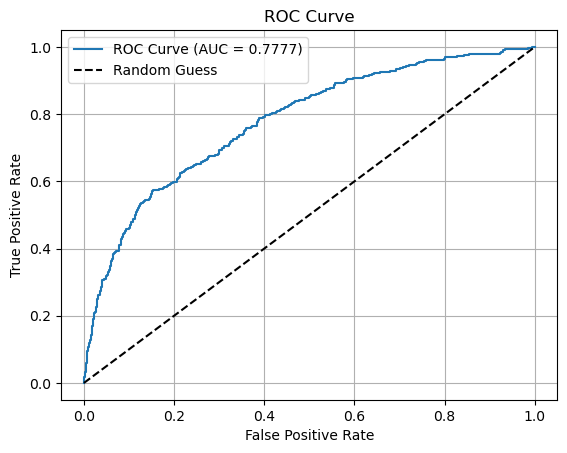

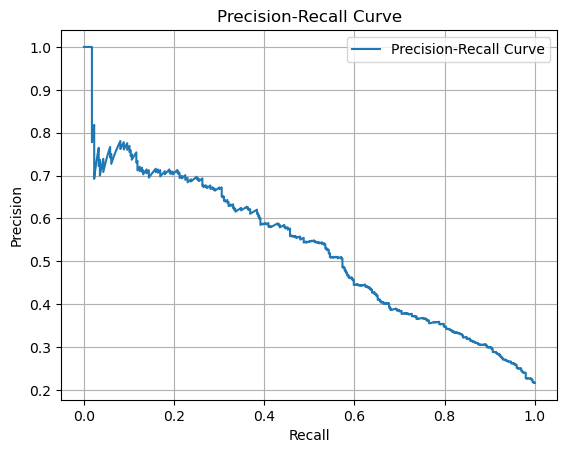

In [18]:
# test_dataset_adni = ADNIDataset(test_dataset)
# test_loader = DataLoader(test_dataset_adni, batch_size=4, shuffle=False)




# Test 데이터 평가 및 성능 지표 계산 함수
def evaluate_classification_task(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for volumes, labels in test_loader:
            volumes, labels = volumes.to(device), labels.to(device)
            outputs = model(volumes).squeeze()
            preds = torch.sigmoid(outputs)  # BCEWithLogitsLoss의 경우 sigmoid 적용
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # NumPy 배열로 변환
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # 이진 분류 기준 (0.5 threshold)
    binary_preds = (all_preds >= 0.7).astype(int)

    # F1 Score
    f1 = f1_score(all_labels, binary_preds)
    print(f"F1 Score: {f1:.4f}")

    # ROC-AUC
    roc_auc = roc_auc_score(all_labels, all_preds)
    print(f"ROC-AUC: {roc_auc:.4f}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, binary_preds)
    print("Confusion Matrix:")
    print(conf_matrix)

    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(all_labels, all_preds)
    plt.figure()
    plt.plot(recall, precision, label="Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()

# 테스트 데이터셋 평가
evaluate_classification_task(model, train_loader, device)
